# Multitask GP Regression using pymc
Source: https://github.com/GAMES-UChile/mogptk/blob/master/examples/example_gold_oil_NASDAQ_USD.ipynb

In [38]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from pymc.sampling_jax import sample_numpyro_nuts
# set the seed
np.random.seed(1)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [39]:
oil     = pd.read_csv('../data/gonu/brent-daily.csv')
oil.set_index("Date", inplace=True)

gold    = pd.read_csv('../data/gonu/lmba-gold-usd-am-daily.csv')
gold = gold.replace(".", np.nan)
gold.Price = gold.Price.astype(float)
gold.set_index("Date", inplace=True)

nasdaq  = pd.read_csv('../data/gonu/nasdaq.csv')
nasdaq  = nasdaq.rename(columns={"Adj Close":"Price"}) 
nasdaq = nasdaq[["Date", "Price"]]
nasdaq.set_index("Date", inplace=True)

usd     = pd.read_csv('../data/gonu/TWEXB.csv')
usd.set_index("Date", inplace=True)

oil.shape, gold.shape, nasdaq.shape, usd.shape

((8186, 1), (13416, 1), (12249, 1), (1286, 1))

(79, 1) Price    0
dtype: int64
(80, 1) Price    0
dtype: int64
(79, 1) Price    0
dtype: int64
(16, 1) Price    0
dtype: int64


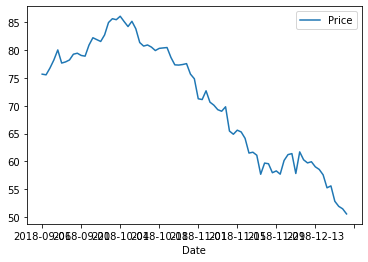

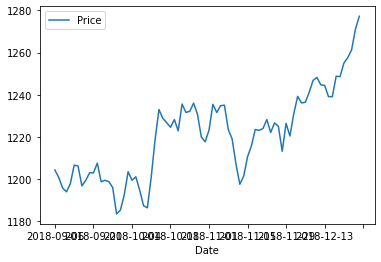

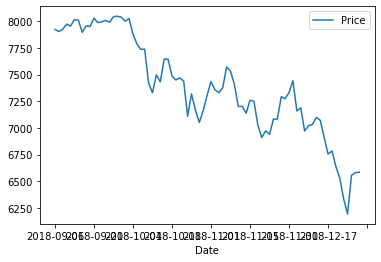

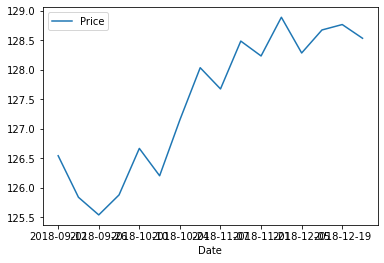

In [40]:
df_list = []
for df in [oil, gold, nasdaq, usd]:
    df = df.loc['2018-09-06':'2018-12-30']
    df = df.dropna()
    df_list.append(df)
    print(df.shape, df.isna().sum())
    df.plot(y="Price")

In [41]:
def build_XY(input_list,output_list=None,index=None):
    num_outputs = len(input_list)
    if output_list is not None:
        assert num_outputs == len(output_list)
        Y = np.vstack(output_list)
    else:
        Y = None

    if index is not None:
        assert len(index) == num_outputs
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,index)] )
    else:
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )

    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])

    return X,Y,I[:,None]#slices

In [42]:
# X1 = np.random.rand(50, 1) * 8
# X2 = np.random.rand(30, 1) * 5

# # build a suitable set of observed variables
# Y1 = np.sin(X1) + np.random.randn(*X1.shape) * 0.05
# Y2 = np.sin(X2) + np.random.randn(*X2.shape) * 0.05 + 2.0
# X1.shape, X2.shape, Y1.shape, Y2.shape

In [43]:
X, Y, I = build_XY([df.reset_index().index.values[:, None] for df in df_list], 
                   [df.Price.values[:, None] for df in df_list])

In [44]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [45]:
X.shape, Y.shape, I.shape, Y.squeeze().shape

((254, 2), (254, 1), (254, 1), (254,))

In [46]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=5, beta=0.1)
    eta = pm.Gamma("eta", alpha=5, beta=0.1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=5, shape=(4,4), initval=np.random.randn(4,4))
    kappa = pm.Gamma("kappa", alpha=5, beta=0.1, shape=4)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=30)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [16]:
%%time
with model:
    gp_trace = pm.sample(500, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 775 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 11.2 s, sys: 8.6 s, total: 19.8 s
Wall time: 13min 4s


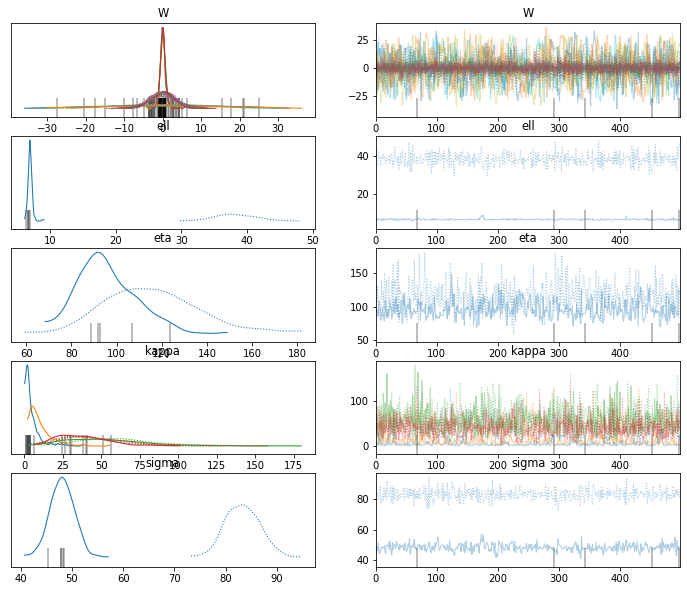

In [47]:
az.plot_trace(gp_trace);

In [22]:
X.shape

(254, 2)

In [19]:
with model:
    preds = gp.conditional("preds", X)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [23]:
with model:
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


(30.0, 100.0)

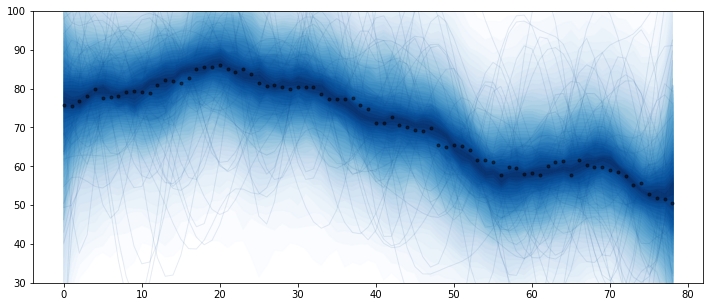

In [48]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:79], X[:79,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X[:79,0], Y[:79,0], 'ok', ms=3, alpha=0.5, label="Data 1");
ax.set_ylim([30, 100])

(1150.0, 1300.0)

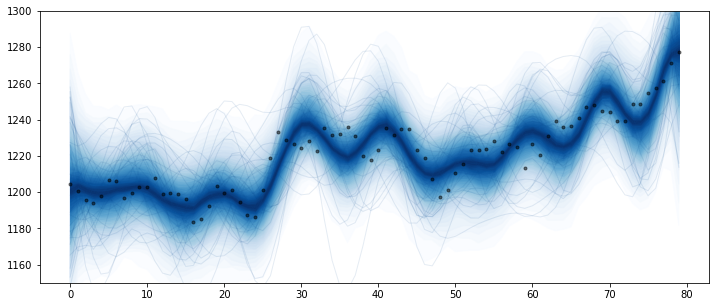

In [52]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,79:159], X[79:159,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X[79:159,0], Y[79:159,0], 'ok', ms=3, alpha=0.5, label="Data 1");
ax.set_ylim([1150, 1300])

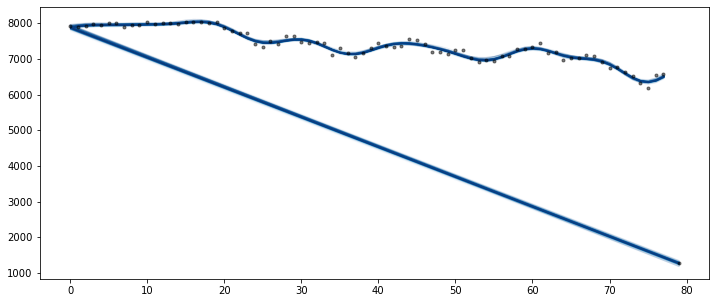

In [55]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,-96:-17], X[-96:-17,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X[-96:-17,0], Y[-96:-17,0], 'ok', ms=3, alpha=0.5, label="Data 1");
# ax.set_ylim([1150, 1300])

(100.0, 150.0)

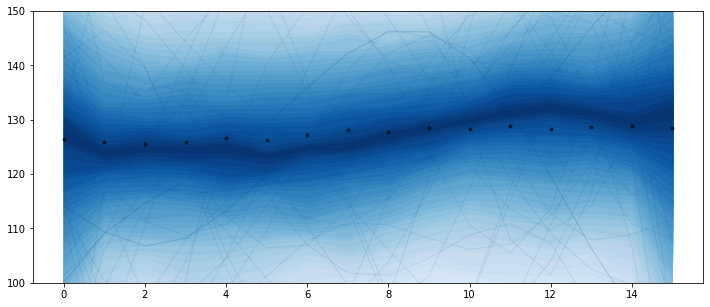

In [54]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,-16:], X[-16:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X[-16:,0], Y[-16:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
ax.set_ylim([100, 150])

In [37]:
coreg.W.eval()

array([[-2.05145825, -2.36255021, -0.06195161, -1.91064943],
       [ 4.2234746 ,  2.16397424,  4.54902502,  3.59516208],
       [-1.92090215,  2.32738012, -3.27055648, -1.56545861],
       [-6.08356198, -0.5112802 , -7.48229801, -1.37518505]])

In [36]:
coreg.B.eval()

array([[ 88.86215323, -20.92769342,   1.635757  ,  16.77913547],
       [-20.92769342, 116.18800679, -23.58241149, -65.78134063],
       [  1.635757  , -23.58241149,  52.51054656,  37.12005741],
       [ 16.77913547, -65.78134063,  37.12005741, 130.5975567 ]])

In [50]:
# %%time
# with model:
#     gp_trace = pm.sample(500, chains=1, target_accept=0.9, init='adapt_diag')